In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -r "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/environment.txt"
!pip install -r "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D/environment.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.1/198.1 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.0 MB/s eta 0:00:00


# Data Description:
 
### Image types: 
* Native T1-weighted (T1): This scan is obtained using a standard T1-weighted imaging sequence, which uses a short TR (repetition time) and a short TE (echo time) to provide high-resolution images of the brain tissue. This sequence highlights the differences in tissue types based on their contrast with the surrounding tissues.

* Post-contrast T1-weighted (T1Gd): This scan is obtained using a T1-weighted imaging sequence after the administration of a contrast agent such as Gadolinium. The contrast agent is injected intravenously and is taken up by cells with a disrupted blood-brain barrier, which is a common characteristic of brain tumors. This sequence highlights the regions of the brain with a disrupted blood-brain barrier, such as enhancing tumor regions.

* T2-weighted (T2): This scan is obtained using a T2-weighted imaging sequence, which uses a long TR and a long TE to provide a more detailed view of the brain tissue. This sequence highlights subtle differences in tissue types that are not visible on T1 scans.

* T2 Fluid Attenuated Inversion Recovery (T2-FLAIR): This scan is obtained using a T2-weighted imaging sequence that is modified to suppress the signal from cerebrospinal fluid (CSF). This is achieved by using an inversion recovery pulse before the T2-weighted acquisition. This sequence is useful for distinguishing between edema and other types of brain tissue because the CSF signal is suppressed.

### Segmentation Classes:
* label 0: No tumor
* label 1: necrotic tumor core (Visible in T2): This class represents the core of the tumor, which is composed of necrotic tissue and non-enhancing tumor cells.
* label 2: the peritumoral edematous/invaded tissue (Visible in flair):  This class represents the edema, or swelling, that occurs around the tumor due to the accumulation of fluid in the surrounding brain tissue.
* label 4: Gd-enhancing tumor (Needs to be converted to 3) (Visible in T1ce): This class represents the region of the tumor that enhances with the administration of contrast agent.

In [ ]:
import tarfile

In [ ]:
my_tarfile = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')
index = my_tarfile.getnames()

In [ ]:
index[: 8]

['.',
 './.DS_Store',
 './BraTS2021_00000',
 './BraTS2021_00000/BraTS2021_00000_flair.nii.gz',
 './BraTS2021_00000/BraTS2021_00000_seg.nii.gz',
 './BraTS2021_00000/BraTS2021_00000_t1.nii.gz',
 './BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz',
 './BraTS2021_00000/BraTS2021_00000_t2.nii.gz']

# Utilities

In [ ]:
import os
import yaml
import importlib


def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)


def check_path_recursively(save_folder, config,
                           params=["model_name", "pretrained_name", "dataset", "similarity_measure", "prompt"]):
    params = [config[i] for i in params if config.get(i) is not None]
    for i in params:
        save_folder = save_folder + "/" + i
        check_path(save_folder)
    config["save_folder"] = save_folder


def yaml_writer(path, contents):
    with open(path, "w") as f:
        yaml.dump(contents, f)


def text_file_reader(path):
    with open(path, "r") as f:
        contents = list(f.readlines())
    contents = [i.split("\n")[0] for i in contents]
    return contents


def text_file_writer(path, contents):
    with open(path, "w") as f:
        for line in contents:
            if isinstance(line, list):
                f.write(" ".join(line))
                f.write("\n")
            else:
                f.write(line + "\n")


def instantiate_attribute(path):
    module_path, attribute_name = path.rsplit(".", 1)
    module = importlib.import_module(module_path)
    return getattr(module, attribute_name)


def instantiate_class(path, params):
    optimizer_attribute = instantiate_attribute(path)
    return optimizer_attribute(params)


# Basic Visualization

In [ ]:
!pip install itkwidgets

In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from ipywidgets import interact
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label, center_of_mass

<ipython-input-37-1e48d0fd498d>:9: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label, center_of_mass
<ipython-input-37-1e48d0fd498d>:9: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label, center_of_mass


In [ ]:
class VisualizePatientData:
    def __init__(self, patient_data_folder, img_type_id):
        self.patient_data_list = sorted(glob.glob(os.path.join(patient_data_folder, "*")))
        self.image_types = ["flair", "seg", "t1", "t1ce", "t2"]
        self.cmap_list = ["gray", "BuPu", "gray", "gray", "gray"]
        self.i = img_type_id
        self.fig = plt.figure(figsize=(1, 1));
    
    def visualize_brain_scans(self, cube_path):
        def create_display(layer):
            self.fig.add_subplot(3, 2, self.i + 1)
            plt.imshow(self.scans[:, :, layer], cmap=self.cmap_list[self.i]);
            plt.axis('off')
            return layer
        self.scans = np.asarray(nib.load(cube_path).get_fdata())
        interact(create_display, layer=(0, self.scans.shape[2] - 1));

    def __call__(self, idx):        
        data_path = os.path.join(self.patient_data_list[idx], "BraTS2021_%05d_%s.nii.gz" % (idx, self.image_types[self.i]))
        self.visualize_brain_scans(data_path)

In [ ]:
patient_data_folder = ""
example_patient_id = 0

In [ ]:
visualizer_flair = VisualizePatientData(patient_data_folder, 0)
visualizer_flair(example_patient_id)

In [ ]:
visualizer_seg = VisualizePatientData(patient_data_folder, 1)
visualizer_seg(example_patient_id)

In [ ]:
visualizer_t1 = VisualizePatientData(patient_data_folder, 2)
visualizer_t1(example_patient_id)

In [ ]:
visualizer_t1ce = VisualizePatientData(patient_data_folder, 3)
visualizer_t1ce(example_patient_id)

In [ ]:
visualizer_t2 = VisualizePatientData(patient_data_folder, 4)
visualizer_t2(example_patient_id)

# Segmentation Classes study

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label, center_of_mass

In [ ]:
patient_data_folder = ""
patient_data_list = sorted(glob.glob(os.path.join(patient_data_folder, "*")))

In [ ]:
core_tumor = []
peritumoral_tissue = []
enhancing_tumor = []
cube_size = 240 * 240 * 155
for i in tqdm(patient_data_list):
    patient_id = i.split("/")[-1].split("_")[-1]
    patient_label_data_path = os.path.join(patient_data_list[i], "BraTS2021_%05s_seg.nii.gz" % (patient_id))
    patient_label_data = nib.load(patient_label_data_path).get_fdata()
    core_tumor.append((len(np.where(patient_label_data == 1)[0]) / cube_size) * 100)
    peritumoral_tissue.append((len(np.where(patient_label_data == 2)[0]) / cube_size) * 100)
    enhancing_tumor.append((len(np.where(patient_label_data == 4)[0]) / cube_size) * 100)

In [ ]:
data = [core_tumor, peritumoral_tissue, enhancing_tumor]
data_string = ["core_tumor", "peritumoral_tissue", "enhancing_tumor"] 
fig = plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if i == 3:
        plt.bar(x=[0, 1, 2], height=[np.average(core_tumor), np.average(peritumoral_tissue), np.average(enhancing_tumor)])
        plt.title("Average volume of %s, %s, %s" % (data_string[0], data_string[1], data_string[2]))
    else:    
        plt.hist(data[i])
        plt.title("Distribution of volume of %s" % data_string[i])

In [ ]:
def visualize_brain_scans(scans):
    def create_display(layer):
        plt.imshow(scans[:, :, layer], cmap="BuPu");
        plt.axis('off')
        return layer
    interact(create_display, layer=(0, scans.shape[2] - 1));

In [ ]:
def compute_centroid_volume_largest_component(seg_labels, label_id):
    seg_labels_core = np.asarray(seg_labels == label_id, dtype=np.uint8)
    labels, num_labels = label(seg_labels_core)
    volumes = []
    for i in range(1, num_labels + 1):
        volume = np.sum(labels == i)
        volumes.append(volume)
    volumes = np.array(volumes)
    if len(volumes):
        largest_components_id = np.argmax(volumes, -1) + 1
        centroid_i = center_of_mass(seg_labels_core, labels=labels, index=largest_components_id)
        volume_i = volumes[largest_components_id - 1]
        return centroid_i, volume_i
    else:
        return None, None

In [ ]:
def centroid_volume_correlation(label_id):
    centroids = []
    volumes = []
    for i in tqdm(patient_data_list):
        patient_id = i.split("/")[-1].split("_")[-1]
        patient_label_data_path = os.path.join(patient_data_list[i], "BraTS2021_%05s_seg.nii.gz" % (patient_id))
        patient_label_data = nib.load(patient_label_data_path).get_fdata()
        centroid_i, volume_i = compute_centroid_volume_largest_component(patient_label_data, label_id)
        if volume_i is None:
            continue
        centroids.append(centroid_i)
        volumes.append(volume_i)
    return centroids, volumes

In [ ]:
label_id = 1
centroids, volumes = centroid_volume_correlation(label_id)
centroids = np.array(centroids)
volumes = np.array(volumes)

In [ ]:
fig = plt.figure(figsize=(120, 120))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=volumes, c=volumes, cmap='BuPu')
ax.set_xlabel('X Centroid', fontsize=100)
ax.set_ylabel('Y Centroid', fontsize=100)
ax.set_zlabel('Z Centroid', fontsize=100)
ax.set_title('Correlation between Centroid and Volume', fontsize=100)
# cbar = plt.colorbar()
# cbar.set_label('Volume')
plt.show()

In [ ]:
label_id = 2
centroids, volumes = centroid_volume_correlation(label_id)
centroids = np.array(centroids)
volumes = np.array(volumes)

In [ ]:
fig = plt.figure(figsize=(120, 120))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=volumes, c=volumes, cmap='BuPu')
ax.set_xlabel('X Centroid', fontsize=100)
ax.set_ylabel('Y Centroid', fontsize=100)
ax.set_zlabel('Z Centroid', fontsize=100)
ax.set_title('Correlation between Centroid and Volume', fontsize=100)
# cbar = plt.colorbar()
# cbar.set_label('Volume')
plt.show()

In [ ]:
label_id = 4
centroids, volumes = centroid_volume_correlation(label_id)
centroids = np.array(centroids)
volumes = np.array(volumes)
fig = plt.figure(figsize=(120, 120))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=volumes, c=volumes, cmap='BuPu')
ax.set_xlabel('X Centroid', fontsize=100)
ax.set_ylabel('Y Centroid', fontsize=100)
ax.set_zlabel('Z Centroid', fontsize=100)
ax.set_title('Correlation between Centroid and Volume', fontsize=100)
# cbar = plt.colorbar()
# cbar.set_label('Volume')
plt.show()

# Generating two splits from a dataset

In [ ]:
import random
import glob
import os
from tqdm import tqdm
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def compute_class_volumes(patient_folder_list):
    core_tumor = []
    peritumoral_tissue = []
    enhancing_tumor = []
    cube_size = 240 * 240 * 155
    for i in tqdm(patient_folder_list):
        patient_id = i.split("/")[-1].split("_")[-1]
        patient_label_data_path = os.path.join(patient_data_list[i], "BraTS2021_%05s_seg.nii.gz" % (patient_id))
        patient_label_data = nib.load(patient_label_data_path).get_fdata()
        core_tumor.append((len(np.where(patient_label_data == 1)[0]) / cube_size) * 100)
        peritumoral_tissue.append((len(np.where(patient_label_data == 2)[0]) / cube_size) * 100)
        enhancing_tumor.append((len(np.where(patient_label_data == 4)[0]) / cube_size) * 100)
    return core_tumor, peritumoral_tissue, enhancing_tumor

In [ ]:
def visualize_class_distributions(data):
    core_tumor, peritumoral_tissue, enhancing_tumor = data
    data_string = ["core_tumor", "peritumoral_tissue", "enhancing_tumor"] 
    fig = plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        if i == 3:
            plt.bar(x=[0, 1, 2], height=[np.average(core_tumor), np.average(peritumoral_tissue), np.average(enhancing_tumor)])
            plt.title("Average volume of %s, %s, %s" % (data_string[0], data_string[1], data_string[2]))
        else:    
            plt.hist(data[i])
            plt.title("Distribution of volume of %s" % data_string[i])
    return np.average(core_tumor), np.average(peritumoral_tissue), np.average(enhancing_tumor)

In [ ]:
def compute_two_splits(data_list, split_ratio):
    continue_loop = True
    while continue_loop:
        list1 = random.sample(data_list, int(0.8 * len(data_list)))
        list2 = [i for i in data_list if i not in list1]
        list1_volumes = compute_class_volumes(list1)
        list2_volumes = compute_class_volumes(list2)
        list1_volumes_averages = [np.average(i) for i in list1_volumes]
        list2_volumes_averages = [np.average(i) for i in list2_volumes]
        overall_averages = [np.average(i + j) for i, j in zip(list1_volumes_averages, list2_volumes_averages)]
        list1_class_proportion = np.divide(list1_volumes_averages, np.sum(list1_volumes_averages))
        list2_class_proportion = np.divide(list2_volumes_averages, np.sum(list2_volumes_averages))
        overall_class_proportion = np.divide(overall_averages, np.sum(overall_averages))
        print("Current split data: ", list1_class_proportion, list2_class_proportion)
        if ((overall_class_proportion[0] - 0.01 <= list1_class_proportion[0] <= overall_class_proportion[0] + 0.01) and
           (overall_class_proportion[1] - 0.01 <= list1_class_proportion[1] <= overall_class_proportion[1] + 0.01) and
           (overall_class_proportion[2] - 0.01 <= list1_class_proportion[2] <= overall_class_proportion[2] + 0.01) and
           (overall_class_proportion[0] - 0.01 <= list2_class_proportion[0] <= overall_class_proportion[0] + 0.01) and
           (overall_class_proportion[1] - 0.01 <= list2_class_proportion[1] <= overall_class_proportion[1] + 0.01) and
           (overall_class_proportion[2] - 0.01 <= list2_class_proportion[2] <= overall_class_proportion[2] + 0.01)):
                return list1, list2

In [ ]:
patient_data_folder = ""
patient_data_list = sorted(glob.glob(os.path.join(patient_data_folder, "*")))[: -2]

In [ ]:
train_split, test_split = compute_two_splits(patient_data_list, 0.8)

In [ ]:
train_volumes = compute_class_volumes(train_split)
test_volumes = compute_class_volumes(test_split)
visualize_class_distributions(train_volumes)

In [ ]:
visualize_class_distributions(test_volumes)

In [ ]:
training_final, validation = compute_two_splits(train_split, 0.8)

In [ ]:
train_final_volumes = compute_class_volumes(training_final)
validation_volumes = compute_class_volumes(validation)
visualize_class_distributions(train_final_volumes)

In [ ]:
visualize_class_distributions(validation_volumes)

# Models

In [ ]:
# Copyright 2020 - 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.blocks import UnetOutBlock
from monai.networks.nets import ViT


class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Tuple[int, int, int],
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        pos_embed: str = "perceptron",
        norm_name: Union[Tuple, str] = "instance",
        conv_block: bool = False,
        res_block: bool = True,
        dropout_rate: float = 0.0,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            img_size: dimension of input image.
            feature_size: dimension of network feature size.
            hidden_size: dimension of hidden layer.
            mlp_dim: dimension of feedforward layer.
            num_heads: number of attention heads.
            pos_embed: position embedding layer type.
            norm_name: feature normalization type and arguments.
            conv_block: bool argument to determine if convolutional block is used.
            res_block: bool argument to determine if residual block is used.
            dropout_rate: faction of the input units to drop.

        Examples::

            # for single channel input 4-channel output with patch size of (96,96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=(96,96,96), feature_size=32, norm_name='batch')

            # for 4-channel input 3-channel output with patch size of (128,128,128), conv position embedding and instance norm
            >>> net = UNETR(in_channels=4, out_channels=3, img_size=(128,128,128), pos_embed='conv', norm_name='instance')

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise AssertionError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise AssertionError("hidden size should be divisible by num_heads.")

        if pos_embed not in ["conv", "perceptron"]:
            raise KeyError(f"Position embedding layer of type {pos_embed} is not supported.")

        self.num_layers = 12
        self.patch_size = (16, 16, 16)  #(16, 16, 16)
        self.feat_size = (
            img_size[0] // self.patch_size[0],
            img_size[1] // self.patch_size[1],
            img_size[2] // self.patch_size[2],
        )
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            pos_embed=pos_embed,
            classification=self.classification,
            dropout_rate=dropout_rate,
        )
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=3, in_channels=feature_size, out_channels=out_channels)  # type: ignore

    def proj_feat(self, x, hidden_size, feat_size):
        x = x.view(x.size(0), feat_size[0], feat_size[1], feat_size[2], hidden_size)
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        return x

    def load_from(self, weights):
        with torch.no_grad():
            res_weight = weights
            # copy weights from patch embedding
            for i in weights["state_dict"]:
                print(i)
            self.vit.patch_embedding.position_embeddings.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.position_embeddings_3d"]
            )
            self.vit.patch_embedding.cls_token.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.cls_token"]
            )
            self.vit.patch_embedding.patch_embeddings[1].weight.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.patch_embeddings.1.weight"]
            )
            self.vit.patch_embedding.patch_embeddings[1].bias.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.patch_embeddings.1.bias"]
            )

            # copy weights from  encoding blocks (default: num of blocks: 12)
            for bname, block in self.vit.blocks.named_children():
                print(block)
                block.loadFrom(weights, n_block=bname)
            # last norm layer of transformer
            self.vit.norm.weight.copy_(weights["state_dict"]["module.transformer.norm.weight"])
            self.vit.norm.bias.copy_(weights["state_dict"]["module.transformer.norm.bias"])

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2, self.hidden_size, self.feat_size))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3, self.hidden_size, self.feat_size))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4, self.hidden_size, self.feat_size))
        dec4 = self.proj_feat(x, self.hidden_size, self.feat_size)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        logits = self.out(out)
        return logits

# Data Generator

In [ ]:
import torch
import nibabel as nib
import numpy as np
import os
import cv2
import glob
import torchvision.transforms as transforms
from monai.transforms.spatial.array import Spacing 
from monai.transforms.intensity.array import NormalizeIntensity, ScaleIntensity

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [152]:
class BTSDataset(torch.utils.data.Dataset):
    def __init__(self, patient_data_list_path, src_folder=None, no_classes=4):
        if src_folder is not None:
          patient_data_list = sorted(text_file_reader(os.path.join(src_folder, patient_data_list_path)))
          patient_data_list = [os.path.join(src_folder, i) for i in patient_data_list]
        else:
          patient_data_list = sorted(text_file_reader(patient_data_list_path))
        self.patient_flair_scans_list = [glob.glob(os.path.join(i, "*_flair.nii.gz"))[0] for i in patient_data_list]
        self.patient_t1ce_scans_list = [glob.glob(os.path.join(i, "*_t1ce.nii.gz"))[0] for i in patient_data_list]
        self.patient_t2_scans_list = [glob.glob(os.path.join(i, "*_t2.nii.gz"))[0] for i in patient_data_list]
        self.patient_seg_scans_list = [glob.glob(os.path.join(i, "*_seg.nii.gz"))[0] for i in patient_data_list]
        self.normalizer = ScaleIntensity()
        self.no_classes = no_classes

    def __len__(self):
        return len(self.patient_flair_scans_list)

    def __getitem__(self, idx):
        t1ce = self.normalizer(torch.Tensor(np.asarray(nib.load(self.patient_t1ce_scans_list[idx]).get_fdata())[:, :, 5: -6]))
        t2 = self.normalizer(torch.Tensor(np.asarray(nib.load(self.patient_t2_scans_list[idx]).get_fdata())[:, :, 5: -6]))
        flair = self.normalizer(torch.Tensor(np.asarray(nib.load(self.patient_flair_scans_list[idx]).get_fdata())[:, :, 5: -6]))
        stacked = torch.stack([t1ce, t2, flair])
        # stacked = Spacing(pixdim=(1.875, 1.875, 1), mode="bilinear")(stacked)
        stacked = Spacing(pixdim=(2.51, 2.51, 1), mode="bilinear")(stacked)
        seg_lbl = np.asarray(nib.load(self.patient_seg_scans_list[idx]).get_fdata())[:, :, 5: -6]
        seg_lbl[seg_lbl == 4] = 3
        # seg_lbl = Spacing(pixdim=(1.875, 1.875, 1), mode="nearest")(seg_lbl[np.newaxis, :, :, :])
        seg_lbl = Spacing(pixdim=(2.51, 2.51, 1), mode="nearest")(seg_lbl[np.newaxis, :, :, :])
        return stacked.to(torch.float32), seg_lbl.to(torch.float32)

In [ ]:
# path = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/dataset/BraTS2021_Training_Data"
# folder_list = sorted(glob.glob(os.path.join(path, "*")))
# folder_list = [i for i in folder_list if os.path.isdir(i)]
# folder_list.pop(354)

In [ ]:
# src_folder = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D"
# folder_list_path = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/dataset/lists/sample_100.txt"
# # patient_data_list = sorted(text_file_reader(folder_list_path))
# # patient_data_list = [os.path.join(src_folder, i) for i in patient_data_list]
# dataset = BTSDataset(folder_list_path, src_folder)

In [ ]:
# ex_idx = 0
# ex_img, ex_label = dataset[ex_idx]
# ex_img.shape, ex_label.shape

# Training setup

In [ ]:
from tqdm import tqdm
import torch
import os
import numpy as np
from monai.losses import DiceLoss


device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["KMP_DUPLICATE_LIB_OK"] = 'True'


class Trainer:
    def __init__(self, model, loss, optimizer, number_of_epochs, weights_save_folder):
        self.loss = instantiate_attribute(loss["path"])(**loss["params"])
        # self.loss = DiceLoss(to_onehot_y=True, include_background=True, softmax=True)
        self.number_of_epochs = number_of_epochs
        self.model = model
        self.model.to("cuda")
        self.optimizer = instantiate_attribute(optimizer["path"])(self.model.parameters(), **optimizer["params"])
        self.best_model_weights = None
        self.weights_save_folder = weights_save_folder
        check_path(self.weights_save_folder)

    def __call__(self, training_dataloader, validation_dataloader):
        average_val_loss = 10 ** 6
        for i in range(self.number_of_epochs):
            print("Epoch number: ", i)
            training_loss = []
            for image, label in tqdm(training_dataloader):
                self.optimizer.zero_grad()
                probabilities = self.model(image.cuda().to(device))
                loss = self.loss(probabilities, label.cuda().to(device))
                loss.backward()
                self.optimizer.step()
                training_loss.append(loss.detach().cpu())
            print("Average training loss: ", np.average(training_loss))
            validation_loss = []
            print("Validating now")
            for image, label in tqdm(validation_dataloader):
                with torch.no_grad():
                    image = image.cuda().to(device)
                    label = label.cuda().to(device)
                    probabilities = self.model(image)
                    image = None
                    torch.cuda.empty_cache()
                    validation_loss.append(self.loss(probabilities, label).cpu())
                    del probabilities, label
            print("Average validation loss: ", np.average(validation_loss))
            if np.average(validation_loss) < average_val_loss:
                self.best_model_weights = self.model.state_dict()
                average_val_loss = np.average(validation_loss)
                torch.save(self.model.state_dict(), os.path.join(self.weights_save_folder, 'model_weights_%d.pth' % i))
        return self.best_model_weights, self.model.to("cpu")


# Evaluation

In [170]:
import numpy as np
import torch
from torchmetrics import JaccardIndex
from torchmetrics import ConfusionMatrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [171]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [172]:
def generate_predictions(model, test_dataloader):
    model.to(device)
    confmat = torch.zeros((4, 4))
    iou_scores = []
    iou_computer = JaccardIndex(task="multiclass", num_classes=4, average="macro")
    confusion_matrix_computer = ConfusionMatrix(task="multiclass", num_classes=4)
    with torch.no_grad():
        for image, label in tqdm(test_dataloader):
            image = image.to(device)
            label = label[0]
            probabilities = model(image)
            probabilities = np.argmax(probabilities, 1)
            # print(probabilities.shape, label.shape)
            iou_scores.append(iou_computer(torch.Tensor(probabilities), label))
            confmat += confusion_matrix_computer(torch.Tensor(probabilities), label) 
    return iou_scores, confmat


In [173]:
config_path = "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D (1)/source_code/configs/unetr_fullscale_training_ncsu.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [174]:
model_weights = "/content/model_weights_25.pth"
model = UNETR(**config["Model"])
model.load_state_dict(torch.load(model_weights, map_location=torch.device(device)))
model.eval();

In [175]:
test_datagenerator = BTSDataset(**config["Test_Dataset"])
test_dataloader = torch.utils.data.DataLoader(test_datagenerator, batch_size=1,
                                                    shuffle=False)

In [176]:
iou_scores, confusion_matrix = generate_predictions(model, test_dataloader)

100%|██████████| 251/251 [44:05<00:00, 10.54s/it]


In [177]:
iou_scores_numpy = [i.numpy() for i in iou_scores]
patient_names = [i.split("/")[-2] for i in test_datagenerator.patient_seg_scans_list]
iou_scores_pd = pd.DataFrame(columns=["Image_name", "Mean_IoU"])
iou_scores_pd["Image_name"] = patient_names
iou_scores_pd["Mean_IoU"] = iou_scores_numpy
iou_scores_pd.to_csv("/content/iou_scores.csv")

In [178]:
columns = ["label_%d_pred" %i for i in range(4)]
rows = ["label_%d_gt" %i for i in range(4)]
confmat_pd = pd.DataFrame(np.asarray(confusion_matrix, np.int32), index=rows, columns=columns).T
confmat_pd.to_csv("/content/confmat.csv")

In [179]:
np.mean(iou_scores)

0.6932387

In [192]:
import pandas as pd
conf_mat = pd.read_csv("/content/confmat.csv")
conf_mat_numpy = conf_mat.to_numpy()
conf_mat_numpy = conf_mat_numpy[:, 1:]
conf_mat_numpy

array([[329130592, 62647, 457668, 90594],
       [2460, 322304, 12605, 15002],
       [149096, 182385, 1833490, 61575],
       [18341, 51215, 38934, 674430]], dtype=object)

In [210]:
class_wise_iou = dict()
classes = ["Background", "necrotic", "peritumoral", "GD-enhancing"]
for i in range(4):
  tp = conf_mat_numpy[i][i]
  fp = sum(conf_mat_numpy[i]) - tp
  fn = sum(conf_mat_numpy[:, i]) - tp
  iou = tp / (tp + fp + fn)
  print(tp, fp, fn, iou)
  class_wise_iou[classes[i]] = iou 

329130592 610909 169897 0.9976332857708663
322304 30067 296247 0.49690881227471334
1833490 393056 509207 0.6701957377000044
674430 108490 167171 0.7098583188347222


In [211]:
class_wise_iou

{'Background': 0.9976332857708663,
 'necrotic': 0.49690881227471334,
 'peritumoral': 0.6701957377000044,
 'GD-enhancing': 0.7098583188347222}

In [212]:
class_wise_iou = {k: [v] for k,v in class_wise_iou.items()}
class_wise_iou_df = pd.DataFrame.from_dict(class_wise_iou)
class_wise_iou_df = class_wise_iou_df.T
class_wise_iou_df.columns = ["IoU"]
class_wise_iou_df.loc[len(class_wise_iou)] = [np.mean(list(class_wise_iou.values()))]
class_wise_iou_df.rename(index={4:'Mean'},inplace=True)
class_wise_iou_df.to_csv("/content/IoU_scores_classwise.csv")
class_wise_iou_df

,IoU
Background,0.997633
necrotic,0.496909
peritumoral,0.670196
GD-enhancing,0.709858
Mean,0.718649


In [209]:
class_wise_iou_df["IoU"]

Background       [0.9976332857708663]
necrotic        [0.49690881227471334]
peritumoral      [0.6701957377000044]
GD-enhancing     [0.7098583188347222]
Mean                         0.718649
Name: IoU, dtype: object

# Experiments

In [ ]:
if not os.path.exists("/content/Experiemnts"):
  os.mkdir("/content/Experiemnts")
# if not os.path.exists("/content/Experiemnts/test"):
#   os.mkdir("/content/Experiemnts/test")

In [ ]:
# config_path = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/source_code/configs/overfitting_test.yaml"
config_path = "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D/source_code/configs/unetr_fullscale_training_ncsu.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [ ]:
model_weights = "/content/model_weights_0.pth"
model = UNETR(**config["Model"])
model.to(device)
model.load_state_dict(torch.load(model_weights))
model.eval();

In [ ]:
training_datagenerator = BTSDataset(**config["Training_Dataset"])
training_dataloader = torch.utils.data.DataLoader(training_datagenerator, batch_size=3,
                                                  shuffle=True)

In [ ]:
validation_datagenerator = BTSDataset(**config["Validation_Dataset"])
validation_dataloader = torch.utils.data.DataLoader(validation_datagenerator, batch_size=3,
                                                    shuffle=False)

In [ ]:
trainer = Trainer(**config["Trainer"], model=model, weights_save_folder=config["save_folder"])

In [ ]:
model_weights, trained_model = trainer(training_dataloader, validation_dataloader)

Epoch number:  0


  0%|          | 0/267 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/monai/transforms/spatial/array.py:570: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")
100%|██████████| 267/267 [1:52:50<00:00, 25.36s/it]


Average training loss:  0.2716391
Validating now


 81%|████████  | 54/67 [20:21<04:49, 22.27s/it]

# data generator sanity check

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
config_path = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/source_code/configs/overfitting_test.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [ ]:
training_datagenerator = BTSDataset(**config["Training_Dataset"])

In [ ]:
ex_img, ex_lbl = training_datagenerator[0]
ex_img.shape, ex_lbl.shape, training_datagenerator.patient_seg_scans_list[0]

/usr/local/lib/python3.9/dist-packages/monai/transforms/spatial/array.py:570: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


((3, 128, 128, 144),
 (1, 128, 128, 144),
 '/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/dataset/BRaTS2021_Training_Data/BraTS2021_00063/BraTS2021_00063_seg.nii.gz')

In [ ]:
ex_lbl_numpy = np.asarray(ex_lbl.numpy(), dtype=np.uint8)
# np.unique(ex_lbl_numpy, return_counts=True)
# ex_lbl_numpy = np.argmax(ex_lbl_numpy, axis=0)
ex_lbl_numpy.shape
np.unique(ex_lbl_numpy, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([2352251,     219,    4051,    2775]))

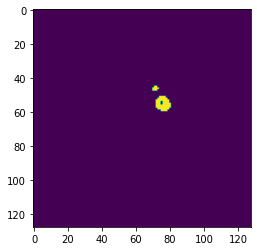

In [ ]:
plt.imshow(ex_lbl_numpy[0, :, :, 108] == 3)

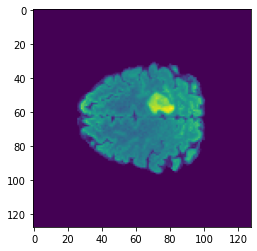

In [ ]:
ex_img_numpy = np.asarray(ex_img.numpy(), dtype=np.float32)
np.histogram(ex_img_numpy[2, :, :, 108])
plt.imshow(ex_img_numpy[2, :, :, 108])

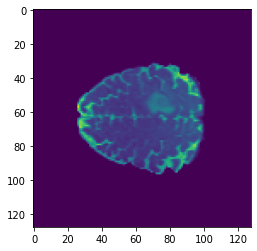

In [ ]:
plt.imshow(ex_img_numpy[1, :, :, 108])

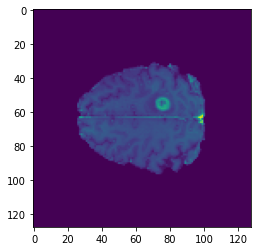

In [ ]:
plt.imshow(ex_img_numpy[0, :, :, 108])

# Model predictions sanity check

In [153]:
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact

In [157]:
# config_path = "/content/drive/MyDrive/Personal/MS/Brain_Tumor_segmentaion3D/source_code/configs/overfitting_test.yaml"
# config_path = "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D/source_code/configs/overfitting_test.yaml"
config_path = "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D (1)/source_code/configs/unetr_fullscale_training_ncsu.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [158]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [159]:
model_weights = "/content/model_weights_25.pth"
model = UNETR(**config["Model"])
model.load_state_dict(torch.load(model_weights, map_location="cpu"))
model.eval();

In [160]:
test_datagenerator = BTSDataset(**config["Test_Dataset"])

In [161]:
ex_img, ex_lbl = test_datagenerator[0]
ex_img.shape, ex_lbl.shape

/usr/local/lib/python3.9/dist-packages/monai/transforms/spatial/array.py:570: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


((3, 96, 96, 144), (1, 96, 96, 144))

In [162]:
class VisualizePredictionSanity:
    def __init__(self, img, lbl, model):
        with torch.no_grad():
          model.to(device)
          self.prediction = model(img.unsqueeze(0).to(device))
          self.prediction = self.prediction.squeeze()
          self.prediction = np.argmax(self.prediction, axis=0)
        self.scans = [lbl.squeeze(), self.prediction]
        self.fig = plt.figure(figsize=(1, 1));
    
    def visualize_brain_scans(self, idx):
        def create_display(layer):
            self.fig.add_subplot(2, 1, idx + 1)
            plt.imshow(scans_i[:, :, layer], cmap="BuPu");
            plt.axis('off')
            return layer
        scans_i = self.scans[idx]
        interact(create_display, layer=(0, scans_i.shape[2] - 1));

    def __call__(self, idx):        
        self.visualize_brain_scans(idx)

In [163]:
visualizer = VisualizePredictionSanity(ex_img, ex_lbl, model)
visualizer(0)

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=71, description='layer', max=143), Output()), _dom_classes=('widget-inte…

In [164]:
visualizer2 = VisualizePredictionSanity(ex_img, ex_lbl, model)
visualizer2(1)

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=71, description='layer', max=143), Output()), _dom_classes=('widget-inte…

In [165]:
np.unique(visualizer2.prediction, return_counts=True), (np.unique(ex_lbl, return_counts=True))

((array([0, 1, 2, 3]), array([1317438,    1117,    5528,    3021])),
 (array([0., 1., 2., 3.], dtype=float32),
  array([1315202,    1681,    8166,    2055])))

In [166]:
from torchmetrics import JaccardIndex
from torchmetrics import ConfusionMatrix

In [167]:
iou_computer = JaccardIndex(task="multiclass", num_classes=4, average="macro")
iou_computer(torch.Tensor(visualizer2.prediction), ex_lbl.squeeze())

tensor(0.7179)
Metadata
	affine: tensor([[2.5100, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.5100, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]], dtype=torch.float64)
	space: RAS

Applied operations
[ { class: 'SpatialResample',
    extra_info: { 'align_corners': False,
                  'dtype': 'float64',
                  'mode': 'nearest',
                  'padding_mode': 'border',
                  'src_affine': tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)},
    id: 140279621163760,
    orig_size: (240, 240, 144)}]
Is batch?: False

In [168]:
confusion_matrix_computer = ConfusionMatrix(task="multiclass", num_classes=4)
confusion_matrix = confusion_matrix_computer(torch.Tensor(visualizer2.prediction), ex_lbl.squeeze())

In [169]:
confusion_matrix

tensor([[1314938,       4,     217,      43],
        [      0,    1100,     260,     321],
        [   2496,       1,    5010,     659],
        [      4,      12,      41,    1998]])
Metadata
	affine: tensor([[2.5100, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.5100, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]], dtype=torch.float64)
	space: RAS

Applied operations
[ { class: 'SpatialResample',
    extra_info: { 'align_corners': False,
                  'dtype': 'float64',
                  'mode': 'nearest',
                  'padding_mode': 'border',
                  'src_affine': tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)},
    id: 140279621163760,
    orig_size: (240, 240, 144)}]
Is batch?: False

# Prediction Visualization

In [213]:
from skimage.measure import marching_cubes 
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [217]:
config_path = "/content/drive/MyDrive/ECE542/Brain_Tumor_segmentaion3D (1)/source_code/configs/unetr_fullscale_training_ncsu.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [218]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [219]:
model_weights = "/content/model_weights_25.pth"
model = UNETR(**config["Model"])
model.load_state_dict(torch.load(model_weights, map_location="cpu"))
model.eval();

In [220]:
test_datagenerator = BTSDataset(**config["Test_Dataset"])

In [221]:
ex_img, ex_lbl = test_datagenerator[10]
ex_img.shape, ex_lbl.shape

/usr/local/lib/python3.9/dist-packages/monai/transforms/spatial/array.py:570: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


((3, 96, 96, 144), (1, 96, 96, 144))

In [222]:
prediction = model(ex_img.unsqueeze(0))
prediction = np.argmax(prediction, 1)

In [223]:
prediction = prediction.squeeze()

In [224]:
np.unique(prediction, return_counts=True), np.unique(ex_lbl[0], return_counts=True)

((array([0, 1, 2, 3]), array([1316270,     273,    9326,    1235])),
 (array([0., 1., 2., 3.], dtype=float32),
  array([1315140,    1683,    9109,    1172])))

In [225]:
# %matplotlib notebook

def plot_3d(prediction):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Set the limits of the axis
  ax.set_xlim([0, 128])
  ax.set_ylim([0, 128])
  ax.set_zlim([0, 144])

  # Create a 3D voxel grid and set the color based on the image intensity
  colors = np.empty(prediction.shape, dtype=object)
  colors[prediction == 0] = 'gray'
  colors[prediction == 1] = '#fbab98' #'red'
  colors[prediction == 2] = '#7A88CCC0' #'blue'
  colors[prediction == 3] = '#e1ffd4'  #'green'
  # ax.voxels(np.asarray(prediction * 0.4 + image[idx] * 0.6, np.int16), facecolors=colors)
  ax.voxels(prediction, facecolors=colors)
  ax.set_aspect('equal')

  # Show the figure
  plt.show()

In [226]:
plot_3d(np.asarray(prediction, np.uint8))

<IPython.core.display.Javascript object>

In [227]:
plot_3d(np.asarray(ex_lbl[0], np.uint8))

<IPython.core.display.Javascript object>